## Instalação de dependências necessárias

In [1]:
!uv add pandas
!uv add numpy
!uv add seaborn
!uv add matplotlib
!uv add scikit-learn

Resolved 50 packages in 0.41ms
Audited 19 packages in 0.04ms
Resolved 50 packages in 0.37ms
Audited 19 packages in 0.04ms
Resolved 50 packages in 0.43ms
Audited 19 packages in 0.04ms
Resolved 50 packages in 0.35ms
Audited 19 packages in 0.03ms
Resolved 50 packages in 0.36ms
Audited 19 packages in 0.05ms


## Importação de dependências

Para dar início no processo de criação do modelo, realizo aqui a importação de todos as dependências que serão utilizadas na execução do projeto.

In [82]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve, roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree



## Carregamento dos dados

Os dados se encontram na pasta `data`. Utilizo a biblioteca `pandas` para poder fazer a leitura do arquivo `csv`.

In [3]:
wine_data_csv_file_path = os.path.join('data', 'winequalityN.csv')
wine_data = pd.read_csv(wine_data_csv_file_path)

wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Modificar o nome das colunas
Com a finalidade de facilitar a manipulação dos dados no futuro, estarei modificando os nomes das colunas removendo espaços, incluindo underscore, deixando tudo minúsculo, etc.

In [4]:
wine_data.columns = wine_data.columns.str.replace(' ', '_').str.lower()
wine_data.columns

Index(['type', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

# Analisando valores nulos

Realizo a análise dos valores nulos para poder ter uma noção dos dados faltantes e realizar o tratamento adequado.

In [5]:
wine_data.isna().sum()

type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
ph                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

# Realizando a limpeza dos valores nulos

Optei por remover as linhas que contém dados nulos. A quantidade de linhas com dados faltantes é bem pequena em relação à base de dados, então pode ser uma solução adequada para este caso.

In [6]:
wine_data.dropna(inplace=True)

wine_data.isna().sum()

type                    0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Criação da variável "opinion"
O exercício solicita que uma variável categórica "opinion" seja criada com base na variável "quality".

- O valor de opinion é 0, quando quality for menor ou igual a 5.
- O valor de opinion é 1, quando quality for maior que 5.

In [7]:
wine_data["opinion"] = np.where(wine_data["quality"] <= 5, 0, 1)

Abaixo realizo a análise do balanceamento das classes para ter um panorama geral do que estou lidando. É possível notar que a base é desbalanceada, contendo mais valores 1 do que 0.

In [8]:
# Analisar o balanceamento das classes
wine_data.opinion.value_counts(normalize=True)

opinion
1    0.632988
0    0.367012
Name: proportion, dtype: float64

### Contagem do total de vinhos de cada tipo
Conforme definido no exercício, devemos utilizar inicialmente somente a base de vinhos do tipo "branco". O dataset fornecido no Kaggle contém vinhos do tipo "branco" e "tinto". Para isso irei inicialmente realizar a contagem do total de vinhos de cada tipo e posteriormente separar as bases de vinhos brancos e tintos. Por último vou fazer a contagem de cada tipo de vinho para se certificar de que não houve alguma remoção acidental.

In [9]:
# Contagem do total de vinhos de cada tipo
print("\n📊 Contagem total de vinhos:")
print(wine_data["type"].value_counts())
print("-"*50)


📊 Contagem total de vinhos:
type
white    4870
red      1593
Name: count, dtype: int64
--------------------------------------------------


In [10]:
# Separação dos vinhos brancos e tintos
white_wine_data = wine_data[wine_data["type"] == "white"]
red_wine_data = wine_data[wine_data["type"] == "red"]

In [11]:
# Certificando que a quantidade de vinhos brancos é a mesma
print("🍾 Vinhos Brancos:")
print(white_wine_data["type"].value_counts())
print("-"*50)

# Certificando que a quantidade de vinhos tintos é a mesma
print("🍷 Vinhos Tintos:")
print(red_wine_data["type"].value_counts())
print("-"*50)

🍾 Vinhos Brancos:
type
white    4870
Name: count, dtype: int64
--------------------------------------------------
🍷 Vinhos Tintos:
type
red    1593
Name: count, dtype: int64
--------------------------------------------------


### Entendendo as variáveis
Antes de começar a análise de dados, é importante entender as variáveis envolvidas.

Com base na análise realizada no dataset, as variáveis se dividem em:
- Categóricas: type, opinion
- Contínua: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, ph, sulphates, alcohol
- Discreta: quality

In [12]:
white_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4870 entries, 0 to 4897
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  4870 non-null   object 
 1   fixed_acidity         4870 non-null   float64
 2   volatile_acidity      4870 non-null   float64
 3   citric_acid           4870 non-null   float64
 4   residual_sugar        4870 non-null   float64
 5   chlorides             4870 non-null   float64
 6   free_sulfur_dioxide   4870 non-null   float64
 7   total_sulfur_dioxide  4870 non-null   float64
 8   density               4870 non-null   float64
 9   ph                    4870 non-null   float64
 10  sulphates             4870 non-null   float64
 11  alcohol               4870 non-null   float64
 12  quality               4870 non-null   int64  
 13  opinion               4870 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 570.7+ KB


#### Obtenção das médias e desvios padrões para cada variável

- Nota: Estou removendo a variável "opinion" por conta dela ser do tipo "categórica" e portanto seria sem sentido fazer média e desvio padrão dela.

In [13]:
white_wine_data.drop(columns=["opinion"]).describe().loc[["mean", "std"]]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
mean,6.855123,0.278071,0.334199,6.394343,0.045771,35.317146,138.340144,0.994026,3.188154,0.489700,10.516772,5.878029
std,0.843444,0.100528,0.120915,5.070853,0.021846,17.012967,42.490515,0.002993,0.150902,0.114196,1.231251,0.885699


# Preparação dos dados

- Remover a variável "quality" que deve ser desconsiderada para a criação do modelo.
- Remover a variável "type" tendo em vista que acima já realizei a separação com base no tipo de vinho (branco ou tinto)

In [14]:
white_wine_data.drop(columns=["quality", "type"], inplace=True)

/var/folders/_z/2mdksj291s782py9yt8kqq1r0000gn/T/ipykernel_12626/2410564594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_wine_data.drop(columns=["quality", "type"], inplace=True)


Abaixo faço a análise de valores nulos, apenas para confirmar de que o dataset não contém valores nulos. Caso houvesse, deveria realizar o tratamento deles.

In [15]:
# Avaliar valores nulos
white_wine_data.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
opinion                 0
dtype: int64

In [16]:
white_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4870 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         4870 non-null   float64
 1   volatile_acidity      4870 non-null   float64
 2   citric_acid           4870 non-null   float64
 3   residual_sugar        4870 non-null   float64
 4   chlorides             4870 non-null   float64
 5   free_sulfur_dioxide   4870 non-null   float64
 6   total_sulfur_dioxide  4870 non-null   float64
 7   density               4870 non-null   float64
 8   ph                    4870 non-null   float64
 9   sulphates             4870 non-null   float64
 10  alcohol               4870 non-null   float64
 11  opinion               4870 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 494.6 KB


# Separabilidade linear

Verificar se existem variáveis que permitem separar linearmente o dataset.

In [17]:
# Avaliação da distribuição de classes
white_wine_data['opinion'].value_counts()

opinion
1    3240
0    1630
Name: count, dtype: int64

In [18]:
# sns.pairplot(data=white_wine_data, hue='opinion')

#### Análise da viabilidade de separação linear

Com base na observação visual dos pares de variáveis plotados acima, não é possível ter certeza se o dataset de vinhos brancos pode ser separado linearmente, ao menos considerando essa visualização em duas dimensões.

## Matriz de confusão

A ideia é avaliar as previsões do modelo. A variável "opinion" é a variável que estamos tentando prever. Nesse caso, vou criar dois modelos fictícios: otimista e pessimista. Após a avaliação das métricas, podemos definir a métrica que servirá como baseline para nosso modelo, ou seja, a métrica que o modelo precisará obter um resultado melhor para poder ser considerado viável.

- Modelo otimista: todos os vinhos são bons
- Modelo pessimista: todos os vinhos são ruins

#### Criação dos modelos otimistas e pessimistas

In [19]:
pessimistic_y = [0] * len(white_wine_data.opinion)
optimistic_y = [1] * len(white_wine_data.opinion)

#### Plotagem da matriz de confusão otimista

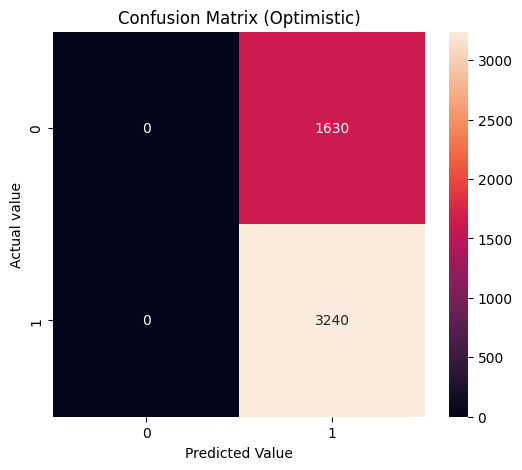

In [20]:
optimistic_confusion_matrix = confusion_matrix(white_wine_data.opinion, optimistic_y)

plt.figure(figsize=(6, 5))
sns.heatmap(optimistic_confusion_matrix, annot=True, fmt="d")
plt.xlabel("Predicted Value")
plt.ylabel("Actual value")
plt.title("Confusion Matrix (Optimistic)")
plt.show()

#### Calculando as métricas para o modelo otimista

Analisando as métricas é possível notar que para o modelo otimista, temos:
- Acurácia: ~0.67
- Precisão: ~0.67
- Recall: 1.00
- F1-score: ~0.80

In [21]:
print('Acurácia (Otimista): ', accuracy_score(white_wine_data.opinion, optimistic_y))
print('Precisão (Otimista): ', precision_score(white_wine_data.opinion, optimistic_y))
print('Recall (Otimista): ', recall_score(white_wine_data.opinion, optimistic_y))
print('F1 Score (Otimista): ', f1_score(white_wine_data.opinion, optimistic_y))

Acurácia (Otimista):  0.6652977412731006
Precisão (Otimista):  0.6652977412731006
Recall (Otimista):  1.0
F1 Score (Otimista):  0.7990135635018496


#### Plotagem da matriz de confusão pessimista

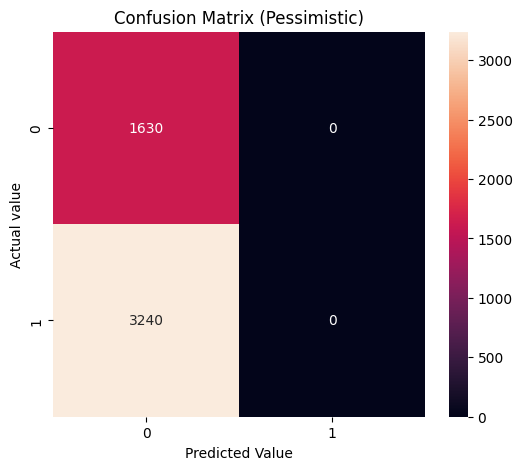

In [22]:
pessimistic_confusion_matrix = confusion_matrix(white_wine_data.opinion, pessimistic_y)

plt.figure(figsize=(6, 5))
sns.heatmap(pessimistic_confusion_matrix, annot=True, fmt="d")
plt.xlabel("Predicted Value")
plt.ylabel("Actual value")
plt.title("Confusion Matrix (Pessimistic)")
plt.show()

#### Calculando as métricas do modelo pessimista

Analisando as métricas é possível notar que para o modelo pessimista, temos:
- Acurácia: ~0.33
- Precisão: 0.0
- Recall: 0.0
- F1-score: 0.0

In [23]:
print('Acurácia (Pessimista): ', accuracy_score(white_wine_data.opinion, pessimistic_y))
print('Precisão (Pessimista): ', precision_score(white_wine_data.opinion, pessimistic_y))
print('Recall (Pessimista): ', recall_score(white_wine_data.opinion, pessimistic_y))
print('F1 Score (Pessimista): ', f1_score(white_wine_data.opinion, pessimistic_y))

Acurácia (Pessimista):  0.3347022587268994
Precisão (Pessimista):  0.0
Recall (Pessimista):  0.0
F1 Score (Pessimista):  0.0


/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
white_wine_data

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,opinion
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4891,5.7,0.21,0.32,0.9,0.038,38.0,121.0,0.99074,3.24,0.46,10.6,1
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1


# Separação entre treino e teste

Irei separar os dados de treino e teste, estabelecendo que os dados de teste corresponderão a 30% do total de dados. Importante destacar que o parâmetro `stratify=y` está sendo utilizado para obter o conjunto de dados proporcional à quantidade contida em cada classe de `opinion`

In [25]:
# separando x e y
target = 'opinion'
X = white_wine_data.drop(columns=[target])
y = white_wine_data[[target]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Análise de proporções

In [26]:
# análise de proporções
props = pd.DataFrame(y.value_counts(normalize=True).values, columns=['original'])
props['train'] = y_train.value_counts(normalize=True).values
props['test'] = y_test.value_counts(normalize=True).values
props

,original,train,test
0,0.665298,0.665298,0.665298
1,0.334702,0.334702,0.334702


Dados totais:


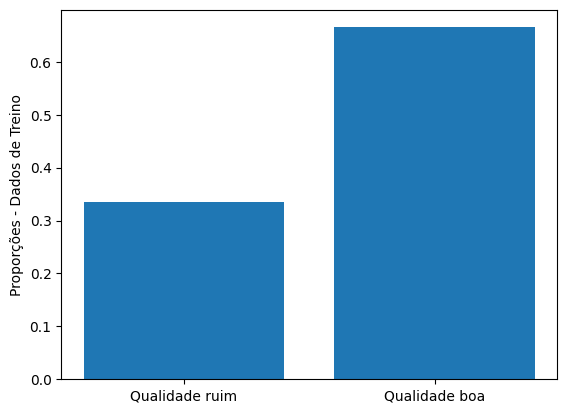

Dados de treino:


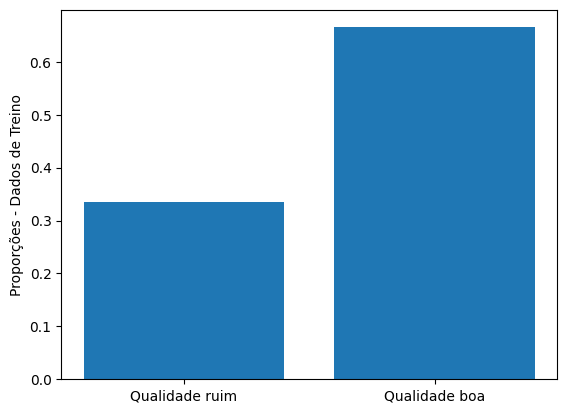

Dados de teste:


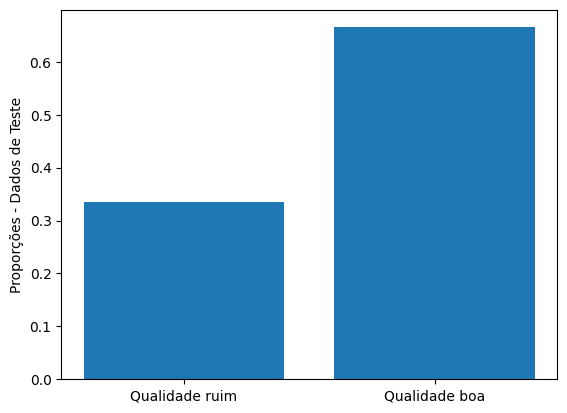

In [33]:
print("Dados totais:")

props = y_train[target].value_counts(normalize=True)

plt.bar(x=props.index, height=props.values)
plt.xticks(ticks=[0, 1], labels=['Qualidade ruim', 'Qualidade boa'])
plt.ylabel('Proporções - Dados de Treino')
plt.show()

print("Dados de treino:")

props = y_train[target].value_counts(normalize=True)

plt.bar(x=props.index, height=props.values)
plt.xticks(ticks=[0, 1], labels=['Qualidade ruim', 'Qualidade boa'])
plt.ylabel('Proporções - Dados de Treino')
plt.show()

print("Dados de teste:")

props = y_test[target].value_counts(normalize=True)

plt.bar(x=props.index, height=props.values)
plt.xticks(ticks=[0, 1], labels=['Qualidade ruim', 'Qualidade boa'])
plt.ylabel('Proporções - Dados de Teste')
plt.show()

#### Criação de um modelo baseline

Abaixo irei criar um modelo baseline com o objetivo de ter uma base para comparar o desempenho. O modelo otimista abaixo servirá como baseline, este modelo é totalmente enviesado e considera que TODOS os vinhos são bons.

In [35]:
y_base = np.repeat(1, repeats=len(y_test))
y_base

array([1, 1, 1, ..., 1, 1, 1], shape=(1461,))

In [36]:
# Calcular métricas do baseline
print(classification_report(y_test, y_base))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       489
           1       0.67      1.00      0.80       972

    accuracy                           0.67      1461
   macro avg       0.33      0.50      0.40      1461
weighted avg       0.44      0.67      0.53      1461



/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precis

A avaliação de grandezas é realizada abaixo para poder avaliar a utilização do processo de Escalonamento, para obtermos uma escala em comum a ser compartilhada pelas diferentes colunas numéricas.

In [37]:
# Avaliar as grandezas do X
X_train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
136,8.2,0.23,0.40,1.20,0.027,36.0,121.0,0.9920,3.12,0.38,10.7
1519,8.3,0.20,0.49,1.70,0.040,34.0,169.0,0.9938,3.05,0.37,10.1
1642,7.3,0.19,0.49,15.55,0.058,50.0,134.0,0.9998,3.42,0.36,9.1
1369,7.4,0.64,0.47,14.15,0.168,42.0,185.0,0.9984,2.90,0.49,9.3
193,6.6,0.15,0.34,5.10,0.055,34.0,125.0,0.9942,3.36,0.42,9.6


Utilizando uma Pipeline, realizo a criação de uma pipeline de modelagem. 

In [38]:
# Criando um pipeline de modelagem
log_reg_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('model', LogisticRegression(penalty=None))
])

log_reg_pipeline.fit(X_train, y_train)

/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('scaler', RobustScaler()),
                ('model', LogisticRegression(penalty=None))])

Realizar previsões com base no modelo e obter as métricas do modelo.

In [39]:
yhat_log_reg = log_reg_pipeline.predict(X_test)

print(classification_report(y_test, yhat_log_reg))

              precision    recall  f1-score   support

           0       0.65      0.48      0.55       489
           1       0.77      0.87      0.82       972

    accuracy                           0.74      1461
   macro avg       0.71      0.67      0.68      1461
weighted avg       0.73      0.74      0.73      1461



# Definição do limiar de decisão ideal

Por padrão, o limiar de decisão é setado em 0.5. 

In [55]:
# Função para obter o melhor threshold

def get_best_threshold(first, second, decision_thresholds):
    first = np.array(first)
    second = np.array(second)

    best_index = np.argmin(np.abs(first - second))
    best_threshold = decision_thresholds[best_index]

    return best_threshold

#### Avaliação a partir do limiar mínimo

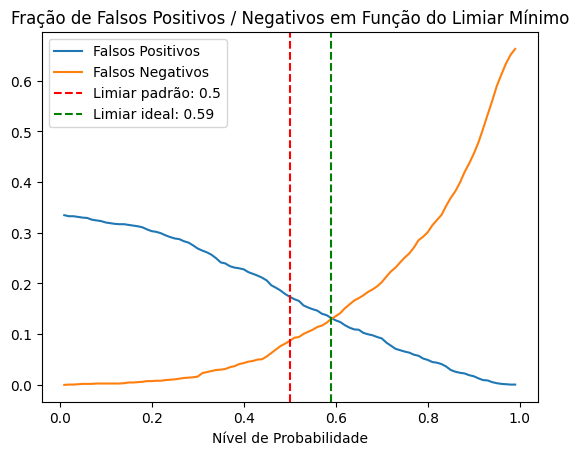

In [61]:
decision_thresholds = np.linspace(0.01, 0.99, 99)

predicted_probabilities = log_reg_pipeline.predict_proba(X_test)

false_positive_rates = []
false_negative_rates = []

for threshold in decision_thresholds:

    yhat = [1 if prob[1] > threshold else 0 for prob in predicted_probabilities]

    confusion_matrix_values = confusion_matrix(y_test, yhat)

    false_positive_rate = confusion_matrix_values[0, 1] / y_test.shape[0]
    false_negative_rate = confusion_matrix_values[1, 0] / y_test.shape[0]

    false_positive_rates.append(false_positive_rate)
    false_negative_rates.append(false_negative_rate)

# Obtendo o melhor threshold
best_threshold = get_best_threshold(false_positive_rates, false_negative_rates, decision_thresholds)

plt.plot(decision_thresholds, false_positive_rates, label='Falsos Positivos')
plt.plot(decision_thresholds, false_negative_rates, label='Falsos Negativos')
plt.title('Fração de Falsos Positivos / Negativos em Função do Limiar Mínimo')
plt.xlabel('Nível de Probabilidade')
plt.axvline(x=0.5, ls='--', color='red', label='Limiar padrão: 0.5')
plt.axvline(x=best_threshold, ls='--', color='green', label=f'Limiar ideal: {best_threshold:.2f}')
plt.legend()
plt.show()

#### Avaliação em termos de precisão e recall

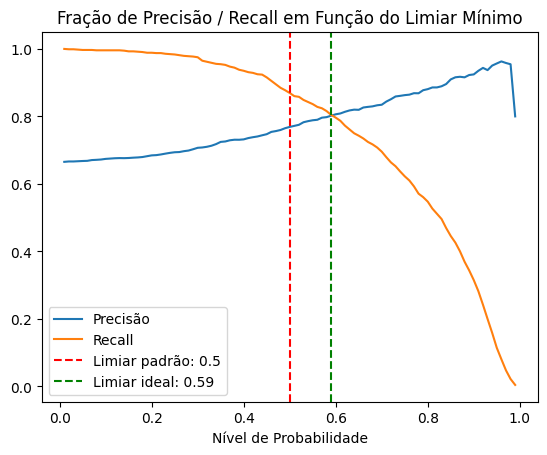

In [60]:
precision = []
recall = []

for threshold in decision_thresholds:
    yhat = [1 if prob[1] > threshold else 0 for prob in predicted_probabilities]

    precision.append(precision_score(y_test, yhat))
    recall.append(recall_score(y_test, yhat))

# Obtendo o melhor threshold
best_threshold = get_best_threshold(precision, recall, decision_thresholds)

plt.plot(decision_thresholds, precision, label='Precisão')
plt.plot(decision_thresholds, recall, label='Recall')
plt.title('Fração de Precisão / Recall em Função do Limiar Mínimo')
plt.xlabel('Nível de Probabilidade')
plt.axvline(x=0.5, ls='--', color='red', label='Limiar padrão: 0.5')
plt.axvline(x=best_threshold, ls='--', color='green', label=f'Limiar ideal: {best_threshold:.2f}')
plt.legend()
plt.show()

In [63]:
yhat_log_reg_with_best_threshold = [1 if prob[1] > best_threshold else 0 for prob in predicted_probabilities]

print(classification_report(y_test, yhat_log_reg))
print(classification_report(y_test, yhat_log_reg_with_best_threshold))

              precision    recall  f1-score   support

           0       0.65      0.48      0.55       489
           1       0.77      0.87      0.82       972

    accuracy                           0.74      1461
   macro avg       0.71      0.67      0.68      1461
weighted avg       0.73      0.74      0.73      1461

              precision    recall  f1-score   support

           0       0.61      0.61      0.61       489
           1       0.80      0.80      0.80       972

    accuracy                           0.74      1461
   macro avg       0.71      0.70      0.71      1461
weighted avg       0.74      0.74      0.74      1461



#### Analisando curva Precisão x Recall da Regressão Logística

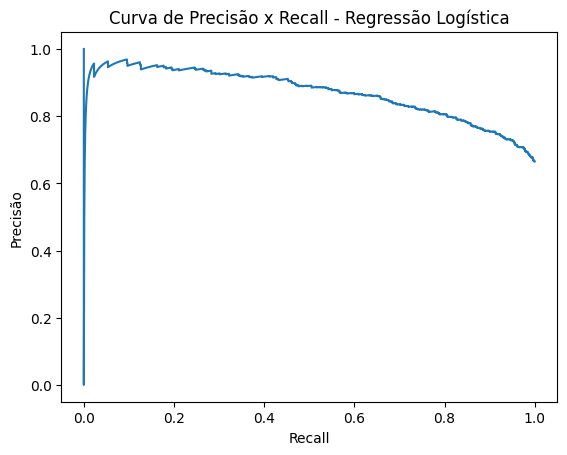

In [50]:
precision, recall, _ = precision_recall_curve(y_test, [prob[1] for prob in predicted_probabilities])

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva de Precisão x Recall - Regressão Logística')
plt.show()

#### Analisando Curva ROC 

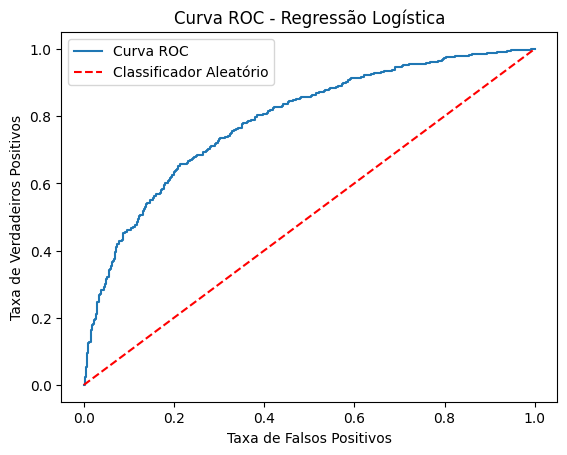

In [53]:
false_positives_rate, true_positives_rate, _ = roc_curve(y_test, [prob[1] for prob in predicted_probabilities])

plt.plot(false_positives_rate, true_positives_rate, label="Curva ROC")
plt.plot([0, 1], [0, 1], ls='--', color='red', label='Classificador Aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Regressão Logística')
plt.legend()
plt.show()

#### Métrica de avaliação rápida da ROC

In [52]:
print('Area abaixo da curva - AUC ROC', roc_auc_score(y_test, [prob[1] for prob in predicted_probabilities]))

Area abaixo da curva - AUC ROC 0.7869549849781615


# Árvore de decisão

In [70]:
decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

Realizando as previsões usando a Decision Tree.

In [71]:
yhat_decision_tree_train = decision_tree.predict(X_train)
yhat_decision_tree_test = decision_tree.predict(X_test)

Realizando a análise de desempenho de cada previsão

In [72]:
# análise de desempenho
print('Base de Treinamento')
print(classification_report(y_train, yhat_decision_tree_train))
print()
print('Base de Teste')
print(classification_report(y_test, yhat_decision_tree_test))

Base de Treinamento
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1141
           1       1.00      1.00      1.00      2268

    accuracy                           1.00      3409
   macro avg       1.00      1.00      1.00      3409
weighted avg       1.00      1.00      1.00      3409


Base de Teste
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       489
           1       0.82      0.83      0.83       972

    accuracy                           0.77      1461
   macro avg       0.74      0.74      0.74      1461
weighted avg       0.77      0.77      0.77      1461



Visualizando a árvore de decisão construída

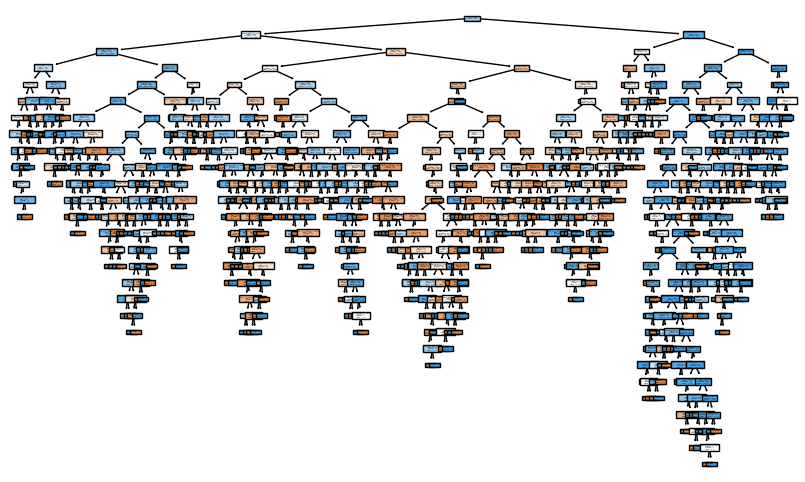

In [73]:
plt.figure(figsize=(10, 6))
plot_tree(decision_tree, feature_names=X_train.columns, filled=True)
plt.show()

Realizando a análise de dimensões da árvore

In [74]:
print('Profundidade:', decision_tree.get_depth())
print('Número de folhas:', decision_tree.get_n_leaves())

Profundidade: 27
Número de folhas: 510


# Determinação de hiperparâmetros

In [77]:
decision_tree_pipeline = Pipeline([
    ('model', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'model__max_depth': range(2, 11),
    'model__criterion': ['gini', 'entropy'],
}

number_of_folds = 10

splitter = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=decision_tree_pipeline,
    param_grid=param_grid,
    cv=splitter,
    refit=True,
    scoring='f1',
    error_score=0,
    verbose=10,
)

Realização da busca

In [78]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10; 1/18] START model__criterion=gini, model__max_depth=2.................
[CV 1/10; 1/18] END model__criterion=gini, model__max_depth=2;, score=0.798 total time=   0.0s
[CV 2/10; 1/18] START model__criterion=gini, model__max_depth=2.................
[CV 2/10; 1/18] END model__criterion=gini, model__max_depth=2;, score=0.812 total time=   0.0s
[CV 3/10; 1/18] START model__criterion=gini, model__max_depth=2.................
[CV 3/10; 1/18] END model__criterion=gini, model__max_depth=2;, score=0.838 total time=   0.0s
[CV 4/10; 1/18] START model__criterion=gini, model__max_depth=2.................
[CV 4/10; 1/18] END model__criterion=gini, model__max_depth=2;, score=0.743 total time=   0.0s
[CV 5/10; 1/18] START model__criterion=gini, model__max_depth=2.................
[CV 5/10; 1/18] END model__criterion=gini, model__max_depth=2;, score=0.809 total time=   0.0s
[CV 6/10; 1/18] START model__criterion=gini, model__max_d

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(2, 11)},
             scoring='f1', verbose=10)

Visualizando a melhor combinação de parâmetros

In [79]:
grid_search.best_params_

{'model__criterion': 'gini', 'model__max_depth': 9}

Visualizando o melhor desempenho médio

In [80]:
grid_search.best_score_

np.float64(0.8298947848997713)

Realizando a análise de desempenho final

In [81]:
yhat_decision_tree_train = grid_search.best_estimator_.predict(X_train)
yhat_decision_tree_test = grid_search.best_estimator_.predict(X_test)

print('Desempenho - base de treino')
print(classification_report(y_train, yhat_decision_tree_train))

print('Desempenho - base de teste')
print(classification_report(y_test, yhat_decision_tree_test))

Desempenho - base de treino
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1141
           1       0.91      0.90      0.91      2268

    accuracy                           0.88      3409
   macro avg       0.86      0.86      0.86      3409
weighted avg       0.88      0.88      0.88      3409

Desempenho - base de teste
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       489
           1       0.80      0.83      0.82       972

    accuracy                           0.75      1461
   macro avg       0.72      0.71      0.72      1461
weighted avg       0.75      0.75      0.75      1461



# SVM

Criação do pipeline de processamento

In [86]:
X.columns.to_list()

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'ph',
 'sulphates',
 'alcohol']

In [99]:
numeric_columns = X.columns.to_list()

pre_processor = ColumnTransformer([
    ('numeric', RobustScaler(), numeric_columns)
])

svc_pipeline = Pipeline([
    ('transformer', pre_processor),
    ('selector', SelectKBest(f_classif)),
    ('model', SVC(random_state=42))
])

svc_param_grid = {
    'selector__k': range(1, 11),
    'model__kernel': ['rbf', 'linear', 'sigmoid', 'cosine', 'poly'],
    'model__C': np.random.uniform(0.01, 10, 50),
    'model__gamma': np.random.uniform(0.001, 1, 50),
    'model__degree': [2, 3],
    'model__class_weight': ['balanced', None]
}

splitter = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=42)

svc_randomized_search = RandomizedSearchCV(
    estimator=svc_pipeline,
    param_distributions=svc_param_grid,
    n_iter=50,
    cv=splitter,
    refit=True,
    scoring='f1',
    error_score=0,
    random_state=42
)

In [100]:
svc_randomized_search.fit(X_train, y_train)

/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               RobustScaler(),
                                                                               ['fixed_acidity',
                                                                                'volatile_acidity',
                                                                                'citric_acid',
                                                                                'residual_sugar',
                                                                                'chlorides',
                                                                                'free_sulfur_dioxide',
                                                                                'total_sulfur_dioxide',
                                                                                'density',
                                                                                'ph',
                                                                                'sulphates',
                                                                                'alcoh...
       0.94386694, 0.45543097, 0.60573193, 0.0268009 , 0.29848245,
       0.47872718, 0.33910591, 0.91632158, 0.18469792, 0.56445151,
       0.20968084, 0.96983546, 0.98538077, 0.29090058, 0.06994436,
       0.14270085, 0.04824006, 0.36352726, 0.07831555, 0.24200594,
       0.50817194, 0.52480253, 0.87421469, 0.55340791, 0.9159011 ]),
                                        'model__kernel': ['rbf', 'linear',
                                                          'sigmoid', 'cosine',
                                                          'poly'],
                                        'selector__k': range(1, 11)},
                   random_state=42, scoring='f1')

Analisando os melhores parâmetros

In [101]:
print('SVC')
svc_randomized_search.best_params_

SVC


{'selector__k': 6,
 'model__kernel': 'rbf',
 'model__gamma': np.float64(0.9159011042928317),
 'model__degree': 2,
 'model__class_weight': None,
 'model__C': np.float64(8.651720946382488)}

Analisando melhores métricas

In [102]:
print('SVC')
svc_randomized_search.best_score_

SVC


np.float64(0.8378601102595373)

In [103]:
yhat_train = svc_randomized_search.best_estimator_.predict(X_train)
yhat_test = svc_randomized_search.best_estimator_.predict(X_test)

print('Base de Treinamento - SVC')
print(classification_report(y_train, yhat_train))
print()
print('Base de Teste - SVC')
print(classification_report(y_test, yhat_test))
print()

Base de Treinamento - SVC
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1141
           1       0.89      0.93      0.91      2268

    accuracy                           0.88      3409
   macro avg       0.87      0.85      0.86      3409
weighted avg       0.88      0.88      0.88      3409


Base de Teste - SVC
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       489
           1       0.80      0.87      0.83       972

    accuracy                           0.77      1461
   macro avg       0.75      0.72      0.73      1461
weighted avg       0.76      0.77      0.76      1461


